In [2]:

import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import numpy as np
import scipy as sp
from matplotlib import pyplot
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.rrule import rrule, DAILY
from scipy.stats import mstats

import statsmodels.tsa as ts
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from statsmodels.tsa.api import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.stattools as stt





In [3]:
########## reading the data and preprocessing for current problem#################
inputData=pd.read_csv('inputDataProcessed.csv', encoding="ISO-8859-1")

inputData.head()


,Store,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,1,01-01-2013,5530,668,0,1,1270,0,1,0,0,0,0,0
1,1,02-01-2013,4327,578,0,1,1270,0,0,1,0,0,0,0
2,1,03-01-2013,4486,619,0,1,1270,0,0,0,1,0,0,0
3,1,04-01-2013,4997,635,0,1,1270,0,0,0,0,1,0,0
4,1,05-01-2013,7176,785,1,1,1270,0,0,0,0,0,1,0


In [4]:
n = len(pd.unique(inputData['Store']))
print(n)

i = 9

15


In [5]:
# plot sales data
storeDataAll=inputData.loc[inputData["Store"]==i]
storeDataAll=storeDataAll.reset_index(drop=True)
    

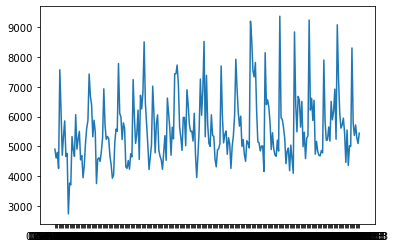

In [6]:
# Create figure and plot space
        
plt.plot( storeDataAll.iloc[0:250,1],storeDataAll.iloc[0:250,2])
        

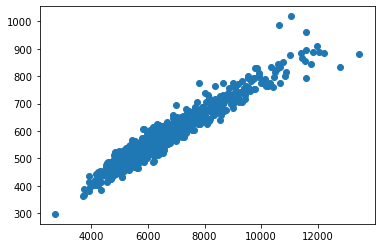

In [7]:

plt.scatter(storeDataAll['Sales'],storeDataAll['Customers'])

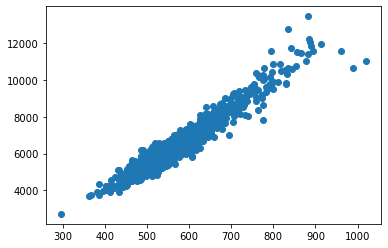

In [8]:
plt.scatter(storeDataAll['Customers'], storeDataAll['Sales'])

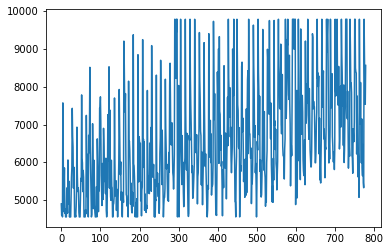

In [9]:
#cap sales Data
transformed_test_data1 = pd.Series(mstats.winsorize(storeDataAll['Sales'], limits=[0.05, 0.05])) 
transformed_test_data1.plot()   

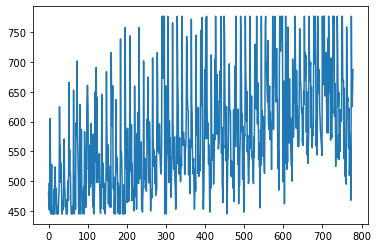

In [10]:
# In[28]:


transformed_test_data2 = pd.Series(mstats.winsorize(storeDataAll['Customers'], limits=[0.05, 0.05])) 
transformed_test_data2.plot()



In [11]:
# get transformed values
storeDataAll.iloc[:,2]=transformed_test_data1.values
storeDataAll.iloc[:,3]=transformed_test_data2.values


In [12]:
storeDataAll.head()

,Store,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,9,01-01-2013,4903,481,0,1,2030,0,0,0,0,0,1,0
1,9,02-01-2013,4602,453,0,1,2030,0,0,0,0,0,0,1
2,9,03-01-2013,4798,497,0,1,2030,1,0,0,0,0,0,0
3,9,04-01-2013,4559,450,0,0,2030,0,1,0,0,0,0,0
4,9,05-01-2013,7574,605,1,0,2030,0,0,1,0,0,0,0


/home/rakesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


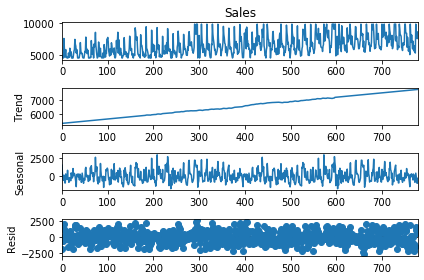

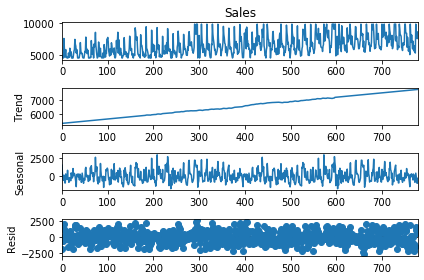

In [13]:

################# get seasonality and trend ##########################
##### change codde to include search for best sesonality using freq#############
    
result = seasonal_decompose((storeDataAll.iloc[:,2]), model='additive', freq=365, extrapolate_trend='freq')
result.plot()

In [14]:
#plot_acf(storeDataAll.iloc[:,2])




In [15]:
print(result.resid.mean())

-7.676707775101318


In [16]:
storeDataAll["SalesSeasonality"]=result.seasonal
storeDataAll["SalesTrend"]=result.trend


/home/rakesh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


-1.5278465512046493


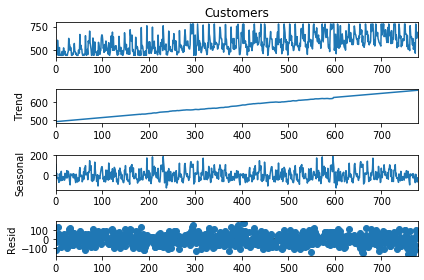

In [17]:
################# get seasonality and trend ##########################
##### change codde to include search for best sesonality using freq#############
result = seasonal_decompose((storeDataAll.iloc[:,3]), model='additive', freq=365, extrapolate_trend='freq')
result.plot()
print(result.resid.mean())
#plot_acf(storeDataAll.iloc[:,3])
storeDataAll["CustSeasonality"]=result.seasonal
storeDataAll["CustTrend"]=result.trend
    
    

In [18]:
###### split data into train and test #########################################
storeOneData, TestData=storeDataAll[:-100], storeDataAll[-100:]


storeOneData.shape, TestData.shape

   

((679, 18), (100, 18))

In [19]:
#################### causality test####################################
## null hypothesis is: x does not granger cause y #####################
## if value of p is less than 0.05 then granger causality exists ######
    
CausalitySales=(ts.stattools.grangercausalitytests(storeOneData[['Sales','Customers']].dropna(),1))
#print(CausalitySales)
CausalityCust=(ts.stattools.grangercausalitytests(storeOneData[['Customers','Sales']].dropna(),1))
#print(CausalityCust)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2058 , p=0.0005  , df_denom=675, df_num=1
ssr based chi2 test:   chi2=12.2601 , p=0.0005  , df=1
likelihood ratio test: chi2=12.1505 , p=0.0005  , df=1
parameter F test:         F=12.2058 , p=0.0005  , df_denom=675, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=36.7752 , p=0.0000  , df_denom=675, df_num=1
ssr based chi2 test:   chi2=36.9387 , p=0.0000  , df=1
likelihood ratio test: chi2=35.9675 , p=0.0000  , df=1
parameter F test:         F=36.7752 , p=0.0000  , df_denom=675, df_num=1


# Sales

In [20]:
####################### stationarity ##################################
## null hypothesis is there is nonstationarity ########################
## if p<0.05 then series is staionary no differencing reqd ############

station=adfuller(storeOneData.iloc[:,2], autolag='AIC')
print('ADF Statistic: %f' % station[0])
print('p-value: %f' % station[1])


ADF Statistic: -2.671509
p-value: 0.079100


In [21]:
if station[4]['5%'] < station[0]:
    stationDIF=adfuller(storeOneData.iloc[:,3].diff().dropna(), autolag='AIC')
    print('ADF Statistic DIFF: %f' % stationDIF[0])
    print('p-value DIFF: %f' % stationDIF[1])

print(station)

ADF Statistic DIFF: -9.534996
p-value DIFF: 0.000000
(-2.6715091655286045, 0.07909951080411748, 20, 658, {'1%': -3.4403271946832645, '5%': -2.8659424728408456, '10%': -2.5691144817582985}, 10984.022945389323)


# Customer

In [22]:
####################### stationarity ##################################
## null hypothesis is there is nonstationarity ########################
## if p<0.05 then series is staionary no differencing reqd ############

station=adfuller(storeOneData.iloc[:,3], autolag='AIC')
print('ADF Statistic: %f' % station[0])
print('p-value: %f' % station[1])

ADF Statistic: -2.545604
p-value: 0.104769


In [23]:
if station[4]['5%'] < station[0]:
    stationDIF=adfuller(storeOneData.iloc[:,3].diff().dropna(), autolag='AIC')
    print('ADF Statistic DIFF: %f' % stationDIF[0])
    print('p-value DIFF: %f' % stationDIF[1])

print(station)


ADF Statistic DIFF: -9.534996
p-value DIFF: 0.000000
(-2.545603735810787, 0.1047689291600416, 20, 658, {'1%': -3.4403271946832645, '5%': -2.8659424728408456, '10%': -2.5691144817582985}, 7404.7820667536635)


In [24]:
# define endogenous and exogenous variables

endog=storeOneData[['Sales', 'Customers']].astype('float32')
    
exog= storeOneData[['Promo', 'SchoolHoliday',
                        'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
                        'DayOfWeek_4','DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_0', 'SalesSeasonality',
                        'SalesTrend', 'CustSeasonality', 'CustTrend']]
exog= exog.astype('float32')
endog=endog.astype('float32')
        

In [41]:
# get the differenced series if required

endogdif1=endog.diff().dropna()
exogdif1=exog.diff().dropna()

endogdif11=endog.iloc[:,0].diff().dropna()
endogdif1.iloc[:,0]=endogdif11.values

endogdif12=endog.iloc[:,1].diff().dropna()
endogdif1.iloc[:,1]=endogdif12.values


In [42]:
#TestDatadif1=TestData.diff().dropna()

In [43]:
#################### cointegration Analysis if required###################################
## null hypothesis is that there is no cointegration ##########################
## to be tested if ADF test says non-stationarity #############################

coint=coint_johansen(endogdif1,0,1)
coint.trace_stat
coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%


In [44]:
N, l = endogdif1.shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)


2


In [45]:
rank=select_coint_rank(endogdif1,0,1)
print(rank.rank)
#result=stt.coint(endog['Sales'], endog['Customers'])


2


In [46]:
#mod = VECM(endogdif1, exog=exogdif1) #endogdif1, exogdif1 
#res = mod.fit() #maxiter=500, disp=False
#res.hessian()
#print(res.summary())



In [47]:
# specify VAR model at levels
mod = VAR(endogdif1, exog=exogdif1) #, order=(2,0,0)

aa=mod.select_order()
aa.summary
print(aa.aic)
res=mod.fit(maxlags=aa.aic, ic='aic')
lag_order = res.k_ar
res.summary()

18


/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/vector_ar/var_model.py:1416: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Dec, 2020
Time:                     23:13:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.6185
Nobs:                     660.000    HQIC:                   19.2017
Log likelihood:          -8022.51    FPE:                1.67834e+08
AIC:                      18.9379    Det(Omega_mle):     1.45028e+08
--------------------------------------------------------------------
Results for equation Sales
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -2.411224        32.597068           -0.074           0.941
Promo                 1346.152788        91.001570           14.793           0.000
SchoolHoliday          158.951682        96.9186

In [48]:
# specify VARMAX model

mod = VARMAX(endogdif1, exog=exogdif1,order=(18,0), trend='n') #endogdif1, exogdif1 
res = mod.fit(maxiter=100, disp=False) #maxiter=500, disp=False
#res.hessian()
print(res.summary())
print(res.params)



/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rakesh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  678
Model:                           VARX(18)   Log Likelihood              -10691.301
Date:                    Mon, 28 Dec 2020   AIC                          21584.602
Time:                            23:17:00   BIC                          22041.036
Sample:                                 0   HQIC                         21761.300
                                    - 678                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              149.50, 951.45   Jarque-Bera (JB):         153.51, 7.24
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.03
Heteroskedasticity (H):         1.04, 1.07   Skew:                     -0.06, -0.10
Prob(H) (two-sided):            0.78, 0.61   Kurtosis:                   5.33, 3.47


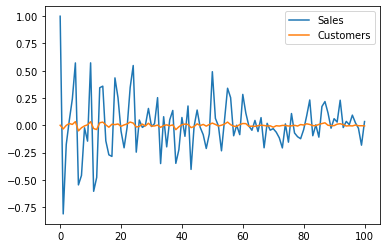

In [33]:
# get impulse response functions
irf=res.impulse_responses(steps=100, orthogonalized=False)
irf.plot()
#res.plot_diagnostics(figsize=(16, 8))


In [49]:
# forecast and get the accuracy of the forecast for differenced series

forecast_input = endogdif1.values[-lag_order:]


In [38]:
exogdif1

,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_0,SalesSeasonality,SalesTrend,CustSeasonality,CustTrend
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1576.312256,3.171875,-112.965309,0.225769
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-18.001686,3.172363,27.365282,0.225769
3,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-533.991577,3.172363,-51.557091,0.225769
4,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,719.802856,3.172363,7.199984,0.225769
5,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,-438.429993,3.172363,-4.459377,0.225769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,188.195984,3.166992,42.507385,0.220825
675,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.064392,3.166992,-32.885769,0.220886
676,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,12.353516,3.166992,28.700537,0.220825
677,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,-84.361633,3.166992,-24.703573,0.220825


In [50]:
forcast=res.forecast(y=forecast_input, steps=678, exog_future=exogdif1)


forcast=pd.DataFrame(forcast)
forcast.head()
forcast.iloc[:,0].plot()

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [39]:
actual=endogdif1[["Sales"]]

In [40]:
actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=forcast.iloc[:,0]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]


NameError: name 'forcast' is not defined

In [ ]:
pred.columns=['ActualSales', 'Sales']
pred.head()


In [ ]:
# plot
pyplot.plot(actual)
pyplot.plot(predicted, color='red')
pyplot.show()


In [ ]:
MPE=np.mean((pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MPE)

MAPE=np.mean(abs(pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MAPE)


In [ ]:

# forecast and get the accuracy of the forecast
forcast=res.forecast(steps=len(endog), exog=exog)
#forcast.iloc[:,0].plot()


In [ ]:
actual=endog[["Sales"]]

In [ ]:
actual.columns=['ActualSales']
actual=actual.reset_index(drop=True)
predicted=forcast[['Sales']]
predicted=predicted.reset_index(drop=True)
pred=pd.merge(actual, predicted, right_index=True, left_index=True)
pred = pred[pred.ActualSales != 0]

In [ ]:

# plot
pyplot.plot(actual)
pyplot.plot(predicted, color='red')
pyplot.show()


In [ ]:
MPE=np.mean((pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MPE)

MAPE=np.mean(abs(pred.ActualSales-pred.Sales)/(pred.ActualSales))
print(MAPE)